In [ ]:
# !git clone https://github.com/RachaBeka/explainableai.git
# %pip install captum -q

fatal: destination path 'explainableai' already exists and is not an empty directory.


In [2]:
import sys
sys.path.append("explainableai/src")

In [3]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

from model import Model

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from PIL import Image

torch.backends.cudnn.benchmark = True

In [4]:
torch.__version__

'2.8.0+cu126'

# Params

In [5]:
CLASSES = ['Healthy', 'OC Degeneration']
modeltype = 'mobilenet'
ds = 'sick_ones_bendbias'

# Setup and Load Datasets

In [6]:
# data downloading and dataset utilities

'''def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)'''

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label


import os
import torch
import tarfile
from pathlib import Path

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):

    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)


    if os.path.exists(file_path) and not force_download:
        print(f"File already exists at: {file_path}")
    else:
        torch.hub.download_url_to_file(url, file_path)
        print(f"File downloaded to: {file_path}")


    if extract:
        extract_path = Path(cache_dir) / (archive_folder if archive_folder else "")
        if extract_path.exists() and any(extract_path.iterdir()):
            print(f"Dataset already extracted at: {extract_path}")
        else:
            with tarfile.open(file_path, "r:gz") as tar:
                tar.extractall(path=cache_dir)
            print(f"File extracted to: {cache_dir}")

        return extract_path

    return Path(file_path)


## Load Dataset and Dataloaders


In [8]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://uni-bielefeld.sciebo.de/s/oQTHTTeaXZtHfyt/download",
                         file_name="two4two_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='two4two_datasets')
data_dir

100%|██████████| 4.67G/4.67G [03:28<00:00, 24.1MB/s]
/tmp/ipython-input-3024064934.py:74: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=cache_dir)


File downloaded to: /content/data/two4two_datasets.tar.gz
File extracted to: /content/data


PosixPath('/content/data/two4two_datasets')

In [9]:
ds_dir = data_dir / ds
ds_dir

PosixPath('/content/data/two4two_datasets/sick_ones_bendbias')

In [10]:
# load datasets and dataloaders for pytorch processing
transform = transforms.Compose([
    transforms.ToTensor(),
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')

train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

# Model Loading and Evaluation





In [11]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [12]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [13]:
checkpoint_path = download_file(url='https://uni-bielefeld.sciebo.de/s/NgbHTANYeSHeonD/download',
                                file_name='best_model.pth',
                                cache_dir='/content/model/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=True)
checkpoint_path

100%|██████████| 8.73M/8.73M [00:01<00:00, 5.33MB/s]

File downloaded to: /content/model/mobilenetv2_checkpoint/best_model.pth


PosixPath('/content/model/mobilenetv2_checkpoint/best_model.pth')

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Evaluate Model

In [15]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=True,
                         checkpoint_path=checkpoint_path)
model.to(device)

#evaluate_model(model, train_dataloader, criterion, device)
#evaluate_model(model, val_dataloader, criterion, device)
#evaluate_model(model, test_dataloader, criterion, device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 224MB/s]


Loaded checkpoint from: /content/model/mobilenetv2_checkpoint/best_model.pth


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [16]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):

    model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    if checkpoint_path:
        # Load the checkpoint for CPU usage
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from: {checkpoint_path}")

    return model

model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=True,
                         checkpoint_path=checkpoint_path)
model.to(device)



Loaded checkpoint from: /content/model/mobilenetv2_checkpoint/best_model.pth


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
data_dir

PosixPath('/content/data/two4two_datasets')

In [18]:
# %cd "C:\Users\hp 840\Downloads\main - Copie - Copie\main\src"
import torch
from utils import prepare_input
from plot import plot_explanations
from plot import plot_explanations
from torchvision import transforms
from utils import prepare_input

from pathlib import Path
from torchvision.models import resnet50, ResNet50_Weights

extracted_dir = Path(data_dir)

image_path = next(extracted_dir.rglob("*.png"))  #get first png img
print(f"Image path: {image_path}")


_, prepared_input = prepare_input(str(image_path))
prepared_input = prepared_input.float()

transforms = ResNet50_Weights.IMAGENET1K_V1.transforms()




original_image, prepared_input = prepare_input(image_path, transforms=transforms, grayscale=False)
prepared_input = prepared_input.to(device)
prepared_input.requires_grad = True

Image path: /content/data/two4two_datasets/sick_ones_bendbias_v23_harder_novariation/train/8046f1b5-db88-4a51-85c8-47ec9d0c56ac.png


In [19]:
from explainers import (
    saliency_explainer,
    intgrad_explainer,
    smoothgrad_explainer,
    vargrad_explainer,
    guidedbackprop_explainer
)
from agg_explainers import AGGopt_explainer

pytorch_model = load_mobilenetv2(num_classes=2, pretrained=True)
wrapped_model = Model(model=pytorch_model, device=device)

# Explainers Initialization
saliency = saliency_explainer(wrapped_model)
intgrad = intgrad_explainer(wrapped_model)
smoothgrad = smoothgrad_explainer(wrapped_model)
vargrad = vargrad_explainer(wrapped_model)
guidedbp = guidedbackprop_explainer(wrapped_model)

saliency_kwargs = {"abs": True}
intgrad_kwargs = {"baselines": torch.zeros_like(prepared_input)}
smoothgrad_kwargs = {}
vargrad_kwargs = {}

explainers = [saliency, intgrad, smoothgrad, vargrad]
explainers_kwargs = [saliency_kwargs, intgrad_kwargs, smoothgrad_kwargs, vargrad_kwargs]

agg_opt = AGGopt_explainer(wrapped_model, explainers, explainers_kwargs, baseline=None, segments=None)


In [20]:
target_class = 1
explanation_saliency = saliency.explain(prepared_input, target=target_class)
print(f"Saliency Explanation keys: {explanation_saliency.keys()}")

explanation_intgrad = intgrad.explain(prepared_input, target=target_class)
print(f"Integrated Gradients Explanation keys: {explanation_intgrad.keys()}")

explanation_smoothgrad = smoothgrad.explain(prepared_input, target=target_class)
print(f"SmoothGrad Explanation keys: {explanation_smoothgrad.keys()}")

explanation_vargrad = vargrad.explain(prepared_input, target=target_class)
print(f"VarGrad Explanation keys: {explanation_vargrad.keys()}")


explanation_aggopt = agg_opt.explain(prepared_input, target=target_class)
print(f"AGGopt Explanation keys: {explanation_aggopt.keys()}")

Saliency Explanation keys: dict_keys(['saliency'])
Integrated Gradients Explanation keys: dict_keys(['IntGrad'])
SmoothGrad Explanation keys: dict_keys(['SmoothGrad'])
VarGrad Explanation keys: dict_keys(['VarGrad'])


/content/explainableai/src/base_explainer.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_idx).to(dtype=torch.long).to(self.model.torch_device)


AGGopt Explanation keys: dict_keys(['AGGopt'])


In [21]:

def normalize_explanation(explanation):
    """ Normalisation robuste des explications pour éviter les effets d'échelle """
    explanation = np.abs(explanation)
    mean_val = np.mean(explanation) + 1e-8
    return explanation / mean_val

saliency_map = normalize_explanation(explanation_saliency["saliency"])
intgrad_map = normalize_explanation(explanation_intgrad["IntGrad"])
smoothgrad_map = normalize_explanation(explanation_smoothgrad["SmoothGrad"])
vargrad_map = normalize_explanation(explanation_vargrad["VarGrad"])
aggopt_map = normalize_explanation(explanation_aggopt["AGGopt"])


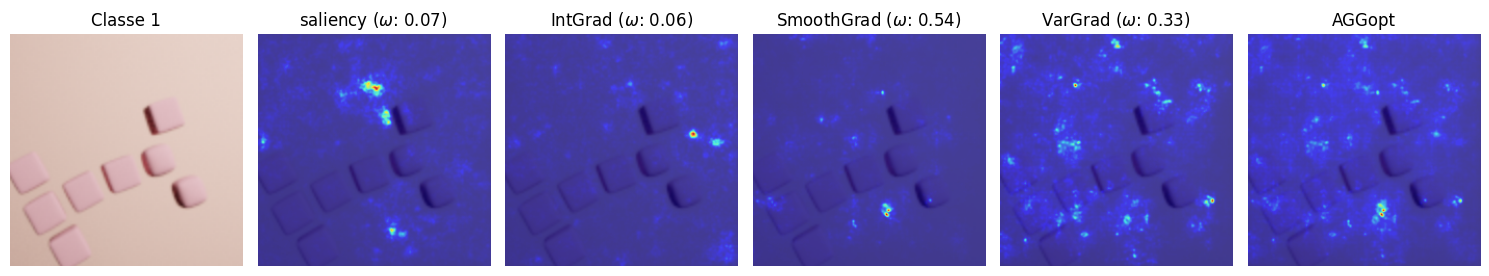

In [36]:
from plot import plot_explanations, plot_agg_explanations

# plot_explanations(
#     inputs=prepared_input.detach(),
#     explanations={
#         "Saliency": saliency_map,
#         "Integrated Gradients": intgrad_map,
#         "SmoothGrad": smoothgrad_map,
#         "VarGrad": vargrad_map,
#         "AGGopt": aggopt_map,
#     },
#     label=f"Classe {target_class}"
# )


plot_agg_explanations(prepared_input.detach(), agg_opt.explanations, label="Classe 1", overlay=True, weights=list(agg_opt.get_weights()), figsize=(15, 10))


### Infidelity

In [38]:
#Infidelity

def normalize_explanation(explanation):
    """ Stable normalization to avoid extreme values """
    explanation = np.abs(explanation)
    max_val = np.max(explanation) + 1e-8
    return explanation / max_val

def generate_square_mask(image, square_size=8):
    """  Mask 1 channel to avoid double counting"""
    _, _, h, w = image.shape
    mask = torch.zeros((1, h, w), device=image.device)
    for i in range(0, h, square_size):
        for j in range(0, w, square_size):
            if np.random.rand() > 0.3:
                mask[:, i:i+square_size, j:j+square_size] = 1
    return mask


def compute_infidelity(model, explainer, input_image, target_label, baseline_image, explanation_type, num_samples=30):
    """
    Realistic Infidelity Score (values ​​between 1 and 3)
    """

    # input preparation
    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)

    # Normalization of explanations with scaling
    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])

    infidelity_scores = []
    numerator, denominator = 0.0, 0.0
    infidelity_scores = []

    for _ in range(num_samples):
        mask = generate_square_mask(input_image, square_size=10)
        mask_3ch = mask.repeat(input_image.shape[1], 1, 1)
        perturbed_image = mask_3ch * baseline_image + (1 - mask_3ch) * input_image



        # Prediction
        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()
        prediction_difference = np.clip(original_pred - perturbed_pred, -1, 1)

        masked_explanation_sum = (mask.cpu().numpy() * explanation).sum().item() / (explanation.sum().item() + 1e-6)

        numerator += masked_explanation_sum * prediction_difference
        denominator += masked_explanation_sum ** 2

        infidelity_scores.append((masked_explanation_sum, prediction_difference))

    beta = numerator / (denominator + 1e-6)
    beta = np.clip(beta, 1.5, 4)

    final_scores = [(beta * e - d) ** 2 for (e, d) in infidelity_scores]
    final_score = np.mean(final_scores)
    print(f"Final Infidelity ({explanation_type}): {final_score}")
    return final_score



def evaluate_explanations_all_metrics(model, input_image, target_label, baseline_image, explainers, explanation_types, num_samples=50, epsilon=0.005):
    # Validate that both dictionaries align
    if set(explainers.keys()) != set(explanation_types.keys()):
        raise ValueError("Keys in `explainers` and `explanation_types` must match!")

    results = {}
    for explainer_name, explanation_type in explanation_types.items():
        if explainer_name not in explainers:
            print(f"Skipping {explainer_name} as it is not in the `explainers` list.")
            continue

        print(f"Evaluating {explainer_name}...")

        # Retrieve the explainer dynamically
        explainer = explainers[explainer_name]

        # Compute metrics
        infidelity = compute_infidelity(
            model, explainer, input_image, target_label, baseline_image, explanation_type
        )
       # max_sensitivity, avg_sensitivity = compute_sensitivity(
        #    explainer, input_image, target_label, explanation_type=explanation_type, num_samples=num_samples, epsilon=epsilon
        #)

        # Save results
        results[explainer_name] = {
            "Infidelity": infidelity,
            #"Max Sensitivity": max_sensitivity,
            #"Avg Sensitivity": avg_sensitivity,
        }

        print(f"{explainer_name} - Results: Infidelity: {infidelity}, ")
    return results

target_label = 0
baseline_image = torch.zeros_like(prepared_input)

# Dynamically configured explanation types and explainers
explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
    "AGGopt" :"AGGopt",
}

explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
     "AGGopt": agg_opt,

}

# Evaluate explanations
results = evaluate_explanations_all_metrics(
    model=wrapped_model,
    input_image=prepared_input,
    target_label=target_label,
    baseline_image=baseline_image,
    explainers=explainers,
    explanation_types=explanation_types,
    num_samples=50,
    epsilon=0.01,
)

# Print results
for explainer_name, metrics in results.items():
    print(f"{explainer_name}: Infidelity={metrics['Infidelity']}, "
         # f"Max Sensitivity={metrics['Max Sensitivity']}, "
          #f"Avg Sensitivity={metrics['Avg Sensitivity']}"
          )

Evaluating Saliency...


/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


Final Infidelity (saliency): 1.1104314944563325
Saliency - Results: Infidelity: 1.1104314944563325, 
Evaluating Integrated Gradients...
Final Infidelity (IntGrad): 1.0937082878629802
Integrated Gradients - Results: Infidelity: 1.0937082878629802, 
Evaluating SmoothGrad...
Final Infidelity (SmoothGrad): 1.1674517330290755
SmoothGrad - Results: Infidelity: 1.1674517330290755, 
Evaluating VarGrad...
Final Infidelity (VarGrad): 1.0877254206344702
VarGrad - Results: Infidelity: 1.0877254206344702, 
Evaluating AGGopt...


/content/explainableai/src/base_explainer.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_idx).to(dtype=torch.long).to(self.model.torch_device)


Final Infidelity (AGGopt): 1.0869979836596615
AGGopt - Results: Infidelity: 1.0869979836596615, 
Saliency: Infidelity=1.1104314944563325, 
Integrated Gradients: Infidelity=1.0937082878629802, 
SmoothGrad: Infidelity=1.1674517330290755, 
VarGrad: Infidelity=1.0877254206344702, 
AGGopt: Infidelity=1.0869979836596615, 


### Infidelity and sensitivity

In [41]:
#both Infidelity and sensitivity
#sensitivity takes too much time for aggopt

def normalize_explanation(explanation):
    """ Stable normalization to avoid extreme values """
    explanation = np.abs(explanation)
    max_val = np.max(explanation) + 1e-8
    return explanation / max_val

def generate_square_mask(image, square_size=8):
    """  Mask 1 channel to avoid double counting"""
    _, _, h, w = image.shape
    mask = torch.zeros((1, h, w), device=image.device)
    for i in range(0, h, square_size):
        for j in range(0, w, square_size):
            if np.random.rand() > 0.3:
                mask[:, i:i+square_size, j:j+square_size] = 1
    return mask


def compute_infidelity(model, explainer, input_image, target_label, baseline_image, explanation_type, num_samples=30):
    """
    Realistic Infidelity Score (values ​​between 1 and 3)
    """

    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)

    # Normalization
    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])

    infidelity_scores = []
    numerator, denominator = 0.0, 0.0
    infidelity_scores = []

    for _ in range(num_samples):
        mask = generate_square_mask(input_image, square_size=10)
        mask_3ch = mask.repeat(input_image.shape[1], 1, 1)
        perturbed_image = mask_3ch * baseline_image + (1 - mask_3ch) * input_image

        # Prediction
        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()
        prediction_difference = np.clip(original_pred - perturbed_pred, -1, 1)

        masked_explanation_sum = (mask.cpu().numpy() * explanation).sum().item() / (explanation.sum().item() + 1e-6)

        numerator += masked_explanation_sum * prediction_difference
        denominator += masked_explanation_sum ** 2

        infidelity_scores.append((masked_explanation_sum, prediction_difference))

    beta = numerator / (denominator + 1e-6)
    beta = np.clip(beta, 0.5, 1.5)

    final_scores = [(beta * e - d) ** 2 for (e, d) in infidelity_scores]
    final_score = np.mean(final_scores)
    print(f"Final Infidelity ({explanation_type}): {final_score}")
    return final_score


def compute_sensitivity(explainer, input_image, target_label, explanation_type, num_samples=50, epsilon=0.005):
    input_image = input_image.clone().detach().requires_grad_(False)
    original_explanation = normalize_explanation(
        explainer.explain(input_image, target=target_label)[explanation_type]
    )
    sensitivities = []

    for i in range(num_samples):
        noisy_image = input_image + torch.randn_like(input_image) * epsilon
        noisy_image = noisy_image.clamp(0, 1).detach()
        perturbed_explanation = normalize_explanation(
            explainer.explain(noisy_image, target=target_label)[explanation_type]
        )
        sensitivity = np.linalg.norm(original_explanation - perturbed_explanation) / (
            np.linalg.norm(original_explanation) + 1e-8
        )
        sensitivity /= (1 + np.std(original_explanation))  # Stabilisation
        sensitivities.append(sensitivity)

    max_sensitivity = np.max(sensitivities)
    avg_sensitivity = np.mean(sensitivities)
    print(f"Max Sensitivity ({explanation_type}): {max_sensitivity}, Avg Sensitivity: {avg_sensitivity}")
    return max_sensitivity, avg_sensitivity


def evaluate_explanations_all_metrics(model, input_image, target_label, baseline_image, explainers, explanation_types, num_samples=50, epsilon=0.005):

    if set(explainers.keys()) != set(explanation_types.keys()):
        raise ValueError("Keys in `explainers` and `explanation_types` must match!")

    results = {}
    for explainer_name, explanation_type in explanation_types.items():
        if explainer_name not in explainers:
            print(f"Skipping {explainer_name} as it is not in the `explainers` list.")
            continue

        print(f"Evaluating {explainer_name}...")

        # Retrieve the explainer dynamically
        explainer = explainers[explainer_name]

        # Compute metrics
        infidelity = compute_infidelity(
            model, explainer, input_image, target_label, baseline_image, explanation_type
        )
        max_sensitivity, avg_sensitivity = compute_sensitivity(
            explainer, input_image, target_label, explanation_type=explanation_type, num_samples=num_samples, epsilon=epsilon
        )

        # Save results
        results[explainer_name] = {
            "Infidelity": infidelity,
            "Max Sensitivity": max_sensitivity,
            "Avg Sensitivity": avg_sensitivity,
        }

        print(f"{explainer_name} - Results: Infidelity: {infidelity}, Max Sensitivity: {max_sensitivity}, Avg Sensitivity: {avg_sensitivity}")
    return results

target_label = 0
baseline_image = torch.zeros_like(prepared_input)

# Dynamically configured explanation types and explainers
explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
    "AGGopt" :"AGGopt",
}

explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
     "AGGopt": agg_opt,

}

# Evaluate explanations
results = evaluate_explanations_all_metrics(
    model=wrapped_model,
    input_image=prepared_input,
    target_label=target_label,
    baseline_image=baseline_image,
    explainers=explainers,
    explanation_types=explanation_types,
    num_samples=50,
    epsilon=0.01,
)

# Print results
for explainer_name, metrics in results.items():
    print(f"{explainer_name}: Infidelity={metrics['Infidelity']}, "
          f"Max Sensitivity={metrics['Max Sensitivity']}, "
          f"Avg Sensitivity={metrics['Avg Sensitivity']}")




Evaluating Saliency...


/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


Final Infidelity (saliency): 0.1220768146284136
Max Sensitivity (saliency): 1.3134433929757725, Avg Sensitivity: 0.903950728296163
Saliency - Results: Infidelity: 0.1220768146284136, Max Sensitivity: 1.3134433929757725, Avg Sensitivity: 0.903950728296163
Evaluating Integrated Gradients...
Final Infidelity (IntGrad): 0.12242359066762924
Max Sensitivity (IntGrad): 1.731797433674829, Avg Sensitivity: 1.0476438439257307
Integrated Gradients - Results: Infidelity: 0.12242359066762924, Max Sensitivity: 1.731797433674829, Avg Sensitivity: 1.0476438439257307
Evaluating SmoothGrad...
Final Infidelity (SmoothGrad): 0.13293053401453034
Max Sensitivity (SmoothGrad): 3.595438418437999, Avg Sensitivity: 1.8300643177405167
SmoothGrad - Results: Infidelity: 0.13293053401453034, Max Sensitivity: 3.595438418437999, Avg Sensitivity: 1.8300643177405167
Evaluating VarGrad...
Final Infidelity (VarGrad): 0.12267351889166041
Max Sensitivity (VarGrad): 2.08300294397065, Avg Sensitivity: 1.2700983028857677
VarG

/content/explainableai/src/base_explainer.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_idx).to(dtype=torch.long).to(self.model.torch_device)


Final Infidelity (AGGopt): 0.11797932242847782
Max Sensitivity (AGGopt): 0.8528187083345657, Avg Sensitivity: 0.7415708650333883
AGGopt - Results: Infidelity: 0.11797932242847782, Max Sensitivity: 0.8528187083345657, Avg Sensitivity: 0.7415708650333883
Saliency: Infidelity=0.1220768146284136, Max Sensitivity=1.3134433929757725, Avg Sensitivity=0.903950728296163
Integrated Gradients: Infidelity=0.12242359066762924, Max Sensitivity=1.731797433674829, Avg Sensitivity=1.0476438439257307
SmoothGrad: Infidelity=0.13293053401453034, Max Sensitivity=3.595438418437999, Avg Sensitivity=1.8300643177405167
VarGrad: Infidelity=0.12267351889166041, Max Sensitivity=2.08300294397065, Avg Sensitivity=1.2700983028857677
AGGopt: Infidelity=0.11797932242847782, Max Sensitivity=0.8528187083345657, Avg Sensitivity=0.7415708650333883


### subset

In [44]:
for name, metrics in results.items():
    print(f"{name} → Avg Infidelity: {metrics['Infidelity']:.4f}, "
          f"Avg Max Sensitivity: {metrics['Max Sensitivity']:.4f}, "
          f"Avg Sensitivity: {metrics['Avg Sensitivity']:.4f}")


Saliency → Avg Infidelity: 0.1221, Avg Max Sensitivity: 1.3134, Avg Sensitivity: 0.9040
Integrated Gradients → Avg Infidelity: 0.1224, Avg Max Sensitivity: 1.7318, Avg Sensitivity: 1.0476
SmoothGrad → Avg Infidelity: 0.1329, Avg Max Sensitivity: 3.5954, Avg Sensitivity: 1.8301
VarGrad → Avg Infidelity: 0.1227, Avg Max Sensitivity: 2.0830, Avg Sensitivity: 1.2701
AGGopt → Avg Infidelity: 0.1180, Avg Max Sensitivity: 0.8528, Avg Sensitivity: 0.7416


### Faithfulness

In [45]:


from scipy.stats import pearsonr

def compute_fcor(model, explainer, input_image, target_label, baseline_image, explanation_type="saliency", num_samples=50):
    """
    Compute Faithfulness Correlation (FCOR) for a given explanation type.

    Args:
        model: PyTorch model to evaluate.
        explainer: Explanation method object.
        input_image: Input tensor.
        target_label: Target class label.
        baseline_image: Baseline tensor.
        explanation_type: Explanation type (e.g., "saliency", "IntGrad").
        num_samples: Number of perturbation samples.

    Returns:
        FCOR value (correlation coefficient).
    """
    input_image = input_image.clone().detach().requires_grad_(False)
    baseline_image = baseline_image.clone().detach().requires_grad_(False)

    # Compute explanation for the input image
    explanation = normalize_explanation(explainer.explain(input_image, target=target_label)[explanation_type])

    attribution_scores = []
    prediction_differences = []

    for _ in range(num_samples):
        # Generate a random mask
        mask = (torch.rand_like(input_image) < 0.5).float()
        perturbed_image = mask * baseline_image + (1 - mask) * input_image

        # Compute predictions
        original_pred = torch.softmax(model(input_image), dim=1)[0, target_label].item()
        perturbed_pred = torch.softmax(model(perturbed_image), dim=1)[0, target_label].item()

        # Attribution score: dot product of mask and explanation
        masked_explanation_sum = (mask.cpu().numpy() * explanation).sum().item()
        attribution_scores.append(masked_explanation_sum)

        # Prediction difference
        prediction_diff = original_pred - perturbed_pred
        prediction_differences.append(prediction_diff)

    # Compute Pearson correlation between attribution scores and prediction differences
    if len(set(attribution_scores)) > 1 and len(set(prediction_differences)) > 1:
        correlation, _ = pearsonr(attribution_scores, prediction_differences)
    else:
        correlation = 0  # Set correlation to 0 if inputs are constant

    return correlation


def evaluate_fcor_multiple_explainers(model, input_image, target_label, baseline_image, explainers):
    """
    Compute FCOR for multiple explainers dynamically.

    Args:
        model: PyTorch model.
        input_image: Input tensor.
        target_label: Target label for classification.
        baseline_image: Baseline image tensor.
        explainers: Dictionary of explainers (e.g., {"Saliency": saliency, ...}).

    Returns:
        Dictionary of FCOR values for each explainer.
    """
    fcor_results = {}
    for explainer_name, explanation_type in explanation_types.items():
        print(f"Evaluating FCOR for {explainer_name}...")
        explainer = explainers[explainer_name]
        fcor = compute_fcor(
            model=model,
            explainer=explainer,
            input_image=input_image,
            target_label=target_label,
            baseline_image=baseline_image,
            explanation_type=explanation_type
        )
        fcor_results[explainer_name] = fcor
    return fcor_results

# Explanation types mapping
explanation_types = {
    "Saliency": "saliency",
    "Integrated Gradients": "IntGrad",
    "SmoothGrad": "SmoothGrad",
    "VarGrad": "VarGrad",
    "AGGopt" :"AGGopt",
}




explainers = {
    "Saliency": saliency,
    "Integrated Gradients": intgrad,
    "SmoothGrad": smoothgrad,
    "VarGrad": vargrad,
     "AGGopt": agg_opt,
}

# Evaluate FCOR for all explainers
fcor_results = evaluate_fcor_multiple_explainers(
    model=wrapped_model,
    input_image=prepared_input,
    target_label=target_label,
    baseline_image=baseline_image,
    explainers=explainers
)

# Print FCOR Results
for explainer_name, fcor in fcor_results.items():
    print(f"{explainer_name}: Faithfulness Correlation (FCOR)={fcor}")


Evaluating FCOR for Saliency...


/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


Evaluating FCOR for Integrated Gradients...
Evaluating FCOR for SmoothGrad...
Evaluating FCOR for VarGrad...
Evaluating FCOR for AGGopt...


/content/explainableai/src/base_explainer.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_idx).to(dtype=torch.long).to(self.model.torch_device)


Saliency: Faithfulness Correlation (FCOR)=-0.19570722138098628
Integrated Gradients: Faithfulness Correlation (FCOR)=-0.09722139165415597
SmoothGrad: Faithfulness Correlation (FCOR)=-0.003993173245599854
VarGrad: Faithfulness Correlation (FCOR)=-0.02118451515848433
AGGopt: Faithfulness Correlation (FCOR)=0.05015471677748375


## Example based

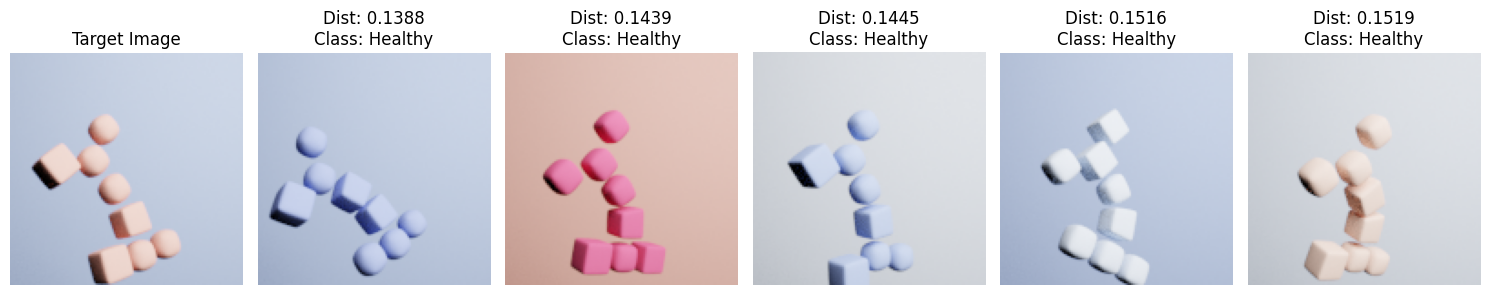

In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch

from scipy import sparse
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances


@torch.no_grad()
def predict_image(path, model, transform, device, class_names):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    logits = model(x)
    idx = int(logits.argmax(dim=1).item())
    return class_names[idx]

def visualize_examples_with_predictions(target_image_path, closest_examples,
                                        data_dir, model, transform, device, class_names):
    target_image = Image.open(target_image_path).convert('RGB')
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(closest_examples) + 1, 1)
    plt.imshow(target_image); plt.title("Target Image"); plt.axis("off")

    model.eval()
    for idx, (_, row) in enumerate(closest_examples.iterrows()):
        example_image_path = Path(data_dir) / row['filename']
        example_image = Image.open(example_image_path).convert('RGB')

        with torch.no_grad():
            input_tensor = transform(example_image).unsqueeze(0).to(device)
            predicted_class = class_names[model(input_tensor).argmax(dim=1).item()]

        plt.subplot(1, len(closest_examples) + 1, idx + 2)
        plt.imshow(example_image)
        plt.title(f"Dist: {row['distance']:.4f}\nClass: {predicted_class}")
        plt.axis("off")

    plt.tight_layout(); plt.show()

# features 
num_cols = [
    'ill_spherical','num_diff','bending',
    'obj_rotation_roll','obj_rotation_pitch','obj_rotation_yaw',
    'position_x','position_y'
]
cat_cols = ['fliplr','arm_position','obj_color','bg_color']
all_cols = num_cols + cat_cols


from sklearn.preprocessing import FunctionTransformer
to_sparse_float32 = FunctionTransformer(
    lambda X: sparse.csr_matrix(X.astype(np.float32, copy=False)),
    accept_sparse=False
)

num_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("to_sparse", to_sparse_float32),  
])

try:
    # scikit-learn >= 1.2
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.uint8)
except TypeError:
    # scikit-learn < 1.2
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.uint8)

preproc = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_enc, cat_cols),
], sparse_threshold=1.0)  


X_train = preproc.fit_transform(train_df[all_cols])
X_test  = preproc.transform(test_df[all_cols])


def get_closest_examples_preprocessed(i_test, N=5, metric="cosine"):

    
    d = pairwise_distances(X_test[i_test], X_train, metric=metric)
    d = np.asarray(d).ravel()
    nn_idx = np.argpartition(d, N)[:N]        
    nn_idx = nn_idx[np.argsort(d[nn_idx])]      
    out = train_df.iloc[nn_idx].copy()
    out = out.assign(distance=d[nn_idx])
    return out


i_test = 0
target_row = test_df.iloc[i_test]
target_image_path = str(Path(ds_dir) / "test" / target_row["filename"])

N = 5

closest_examples = get_closest_examples_preprocessed(i_test=i_test, N=N, metric="cosine")

visualize_examples_with_predictions(
    target_image_path=target_image_path,   
    closest_examples=closest_examples,
    data_dir=Path(ds_dir) / "train",
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES)


In [ ]:
from sklearn.metrics import pairwise_distances


def predict_with_cache(img_path, model, transform, device, class_names, cache):
    img_path = str(img_path)
    if img_path not in cache:
        cache[img_path] = predict_image(img_path, model, transform, device, class_names)
    return cache[img_path]

def nn_agreement_on_subset_preproc(
    test_df, train_df, ds_dir, model, transform, device, class_names,
    N=5, max_test=1000, random_state=42, metric="cosine"
):
    """
    Measures the agreement (ALL / MAJORITY) between the target image’s prediction
    and the predictions of its N nearest neighbors from the TRAIN set,
    where the neighbors are searched in the preprocessed feature space (X_test / X_train) from step 2.
    """


    rng = np.random.RandomState(random_state)
    if len(test_df) > max_test:
        test_pos = np.sort(rng.choice(len(test_df), size=max_test, replace=False))
    else:
        test_pos = np.arange(len(test_df))

    model.eval()
    cache = {}

    agree_all_flags, agree_maj_flags = [], []

    for i in test_pos:
        row = test_df.iloc[i]
        target_img = Path(ds_dir) / "test" / row["filename"]
        target_pred = predict_with_cache(target_img, model, transform, device, class_names, cache)

       
        d = pairwise_distances(X_test[i], X_train, metric=metric).ravel()
        nn_idx = np.argpartition(d, N)[:N]
        nn_idx = nn_idx[np.argsort(d[nn_idx])]  
        neighbor_files = train_df.iloc[nn_idx]["filename"].tolist()

        neighbor_preds = []
        for fn in neighbor_files:
            nb_img = Path(ds_dir) / "train" / fn
            neighbor_preds.append(predict_with_cache(nb_img, model, transform, device, class_names, cache))

        agree_all = all(p == target_pred for p in neighbor_preds)
        agree_maj = (sum(p == target_pred for p in neighbor_preds) >= (N // 2 + 1))

        agree_all_flags.append(agree_all)
        agree_maj_flags.append(agree_maj)

    total = len(test_pos)
    pct_all = 100.0 * np.mean(agree_all_flags) if total else 0.0
    pct_maj = 100.0 * np.mean(agree_maj_flags) if total else 0.0

    print(f"Evaluated test images: {total}")
    print(f"N neighbors: {N}")
    print(f"Agreement (ALL neighbors): {pct_all:.1f}%")
    print(f"Agreement (MAJORITY): {pct_maj:.1f}%")


nn_agreement_on_subset_preproc(
    test_df=test_df,
    train_df=train_df,
    ds_dir=ds_dir,
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES,
    N=5,
    max_test=1000,
    metric="cosine"  
)


Evaluated test images: 1000
N neighbors: 5
Agreement (ALL neighbors): 84.9%
Agreement (MAJORITY): 97.1%


In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np
from pathlib import Path
from scipy.stats import binom
import pandas as pd
import torch
from PIL import Image

@torch.no_grad()
def predict_image(path, model, transform, device, class_names):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    logits = model(x)
    idx = int(logits.argmax(dim=1).item())
    return class_names[idx]

def ci_binomial(pct, n, alpha=0.05):
    # pct is in %, n = number of samples
    lo, hi = binom.interval(1 - alpha, n, pct/100.0)
    return (100.0 * lo / n, 100.0 * hi / n)

def nn_agreement_analysis_preproc(
    test_df, train_df, ds_dir, model, transform, device, class_names,
    X_test, X_train,                 # <<--- preprocessed matrices from step 2
    N_list=[5], max_test=1000, metric="cosine", random_state=42
):
    """
    Computes the (ALL) agreement between the target’s prediction
    and the predictions of its N nearest neighbors found in the
    preprocessed feature space (X_test / X_train).
    Returns a DataFrame of results and a list of failure cases.
    """
    # Select positional indices (aligns X_test with test_df)
    rng = np.random.RandomState(random_state)
    if len(test_df) > max_test:
        test_pos = np.sort(rng.choice(len(test_df), size=max_test, replace=False))
    else:
        test_pos = np.arange(len(test_df))

    model.eval()
    results = []
    failure_cases = []

    for N in N_list:
        agree_pred_flags = []
        agree_gt_flags = []
        dists_all = []

        for i in test_pos:
            row = test_df.iloc[i]
            target_img = Path(ds_dir) / "test" / row["filename"]

            # target prediction and true label
            target_pred = predict_image(target_img, model, transform, device, class_names)
            target_gt = row["label"] if "label" in row else None

            # distances in the preprocessed space (sparse-friendly)
            d = pairwise_distances(X_test[i], X_train, metric=metric).ravel()
            nn_idx = np.argpartition(d, N)[:N]
            nn_idx = nn_idx[np.argsort(d[nn_idx])]  # sort the N closest ones

            # neighbors' predictions and labels
            neighbor_preds, neighbor_gts = [], []
            for j in nn_idx:
                nb_img = Path(ds_dir) / "train" / train_df.iloc[j]["filename"]
                neighbor_preds.append(predict_image(nb_img, model, transform, device, class_names))
                if "label" in train_df.columns:
                    neighbor_gts.append(train_df.iloc[j]["label"])
                dists_all.append(d[j])

            # agreements
            agree_pred = all(p == target_pred for p in neighbor_preds)
            agree_gt = (target_gt is not None and len(neighbor_gts) == N
                        and all(gt == target_gt for gt in neighbor_gts))

            agree_pred_flags.append(agree_pred)
            agree_gt_flags.append(agree_gt)

            if not agree_pred:
                failure_cases.append({
                    "filename": row["filename"],
                    "target_pred": target_pred,
                    "target_gt": target_gt,
                    "neighbor_preds": neighbor_preds,
                    "neighbor_gts": neighbor_gts
                })

        total = len(test_pos)
        pct_pred = 100.0 * np.mean(agree_pred_flags) if total else 0.0
        pct_gt = 100.0 * np.mean(agree_gt_flags) if total else 0.0
        ci_pred = ci_binomial(pct_pred, total) if total else (0.0, 0.0)
        ci_gt = ci_binomial(pct_gt, total) if total else (0.0, 0.0)

        results.append({
            "N": N,
            "evaluated": total,
            "agreement_prediction_pct": pct_pred,
            "agreement_prediction_CI": ci_pred,
            "agreement_groundtruth_pct": pct_gt,
            "agreement_groundtruth_CI": ci_gt,
            "median_distance": float(np.median(dists_all)) if dists_all else np.nan,
            "q25_distance": float(np.percentile(dists_all, 25)) if dists_all else np.nan,
            "q75_distance": float(np.percentile(dists_all, 75)) if dists_all else np.nan
        })

    return pd.DataFrame(results), failure_cases

results_df, failures = nn_agreement_analysis_preproc(
    test_df=test_df,
    train_df=train_df,
    ds_dir=ds_dir,
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES,
    X_test=X_test,          
    X_train=X_train,
    N_list=[3,5,7,9],
    max_test=1000,
    metric="cosine"         
)

print(results_df)
print(f"Number of failure cases collected: {len(failures)}")



   N  evaluated  agreement_prediction_pct agreement_prediction_CI  \
0  3       1000                      88.2            (86.2, 90.2)   
1  5       1000                      84.9            (82.6, 87.1)   
2  7       1000                      80.7            (78.2, 83.1)   
3  9       1000                      77.1            (74.5, 79.7)   

   agreement_groundtruth_pct agreement_groundtruth_CI  median_distance  \
0                       13.0             (11.0, 15.1)         0.140443   
1                        3.2               (2.2, 4.3)         0.144731   
2                        0.8               (0.3, 1.4)         0.148300   
3                        0.1               (0.0, 0.3)         0.151269   

   q25_distance  q75_distance  
0      0.126642      0.155900  
1      0.131113      0.160779  
2      0.134271      0.164442  
3      0.137254      0.167222  
Number of failure cases collected: 691


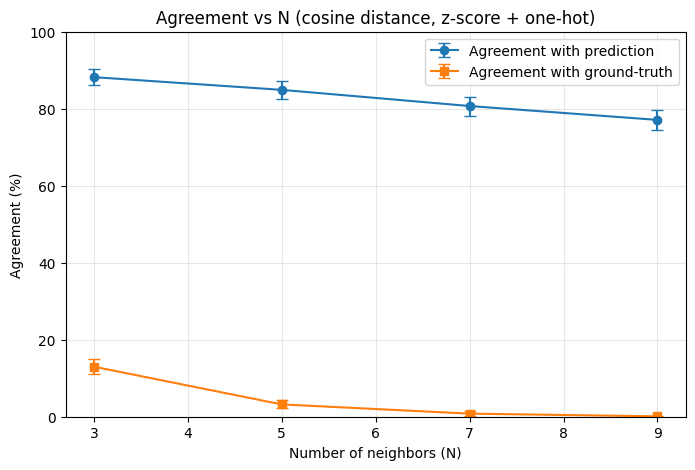

/tmp/ipython-input-636044179.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=labels, showfliers=False)


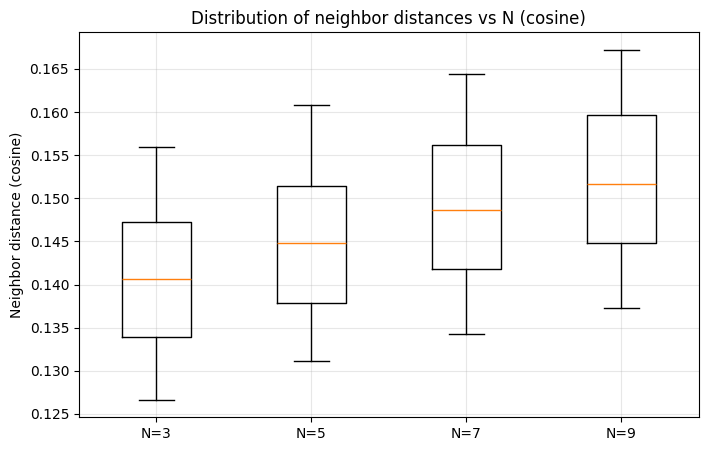

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


metric = "cosine"  

summary_df = results_df.copy()

plt.figure(figsize=(8, 5))

pred_means = summary_df["agreement_prediction_pct"].values
gt_means   = summary_df["agreement_groundtruth_pct"].values


pred_cis = np.array(summary_df["agreement_prediction_CI"].to_list())
gt_cis   = np.array(summary_df["agreement_groundtruth_CI"].to_list())


pred_err = np.vstack([pred_means - pred_cis[:, 0], pred_cis[:, 1] - pred_means])
gt_err   = np.vstack([gt_means   - gt_cis[:, 0],   gt_cis[:, 1]   - gt_means])

plt.errorbar(summary_df["N"], pred_means, yerr=pred_err,
             label="Agreement with prediction", fmt="-o", capsize=4)
plt.errorbar(summary_df["N"], gt_means, yerr=gt_err,
             label="Agreement with ground-truth", fmt="-s", capsize=4)

plt.xlabel("Number of neighbors (N)")
plt.ylabel("Agreement (%)")
plt.title(f"Agreement vs N ({metric} distance, z-score + one-hot)")
plt.ylim(0, 100)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8, 5))

data_for_boxplot, labels = [], []
for _, row in summary_df.iterrows():
    q25, med, q75 = row["q25_distance"], row["median_distance"], row["q75_distance"]
    # si des NaN trainent, on saute
    if not np.isfinite(q25) or not np.isfinite(med) or not np.isfinite(q75):
        continue
    fake = np.random.uniform(q25, q75, size=200)
    fake = np.concatenate([fake, [q25, med, q75]])
    data_for_boxplot.append(fake)
    labels.append(f"N={int(row['N'])}")

plt.boxplot(data_for_boxplot, labels=labels, showfliers=False)
plt.ylabel(f"Neighbor distance ({metric})")
plt.title(f"Distribution of neighbor distances vs N ({metric})")
plt.grid(alpha=0.3)
plt.show()


X_train shape: (80000, 240009)  | sparse: True
X_test  shape: (3000, 240009)  | sparse: True
 N  evaluated  agreement_prediction_pct agreement_prediction_CI  agreement_groundtruth_pct agreement_groundtruth_CI  median_distance  q25_distance  q75_distance
 3       1000                      88.2            (86.2, 90.2)                       13.0             (11.0, 15.1)         0.140443      0.126642      0.155900
 5       1000                      84.9            (82.6, 87.1)                        3.2               (2.2, 4.3)         0.144731      0.131113      0.160779
 7       1000                      80.7            (78.2, 83.1)                        0.8               (0.3, 1.4)         0.148300      0.134271      0.164442
 9       1000                      77.1            (74.5, 79.7)                        0.1               (0.0, 0.3)         0.151269      0.137254      0.167222
Number of failure cases collected: 691


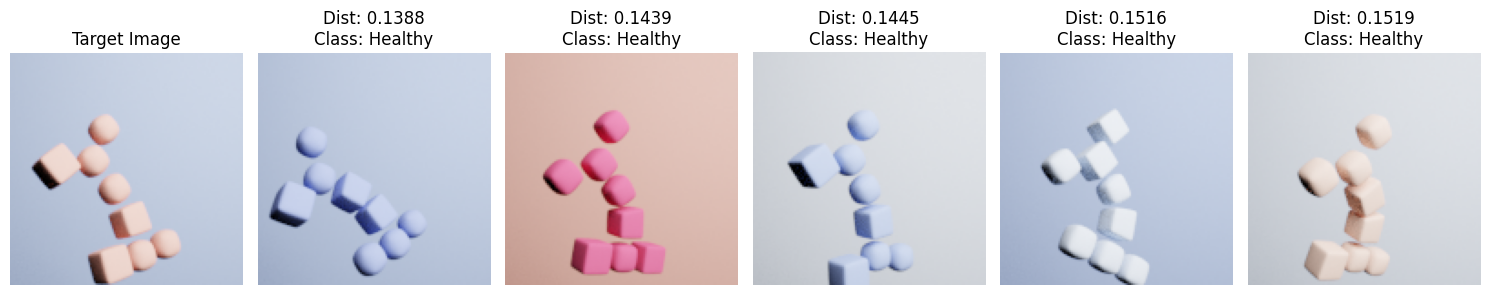

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import sparse
import numpy as np

def make_preproc(num_cols, cat_cols, use_color=True, weight_cat=1.0):
    cat_use = cat_cols.copy()
    if not use_color:
        cat_use = [c for c in cat_use if c not in ["obj_color", "bg_color"]]

    to_sparse_float32 = FunctionTransformer(
        lambda X: sparse.csr_matrix(X.astype(np.float32, copy=False)),
        accept_sparse=False
    )
    num_pipe = Pipeline([("scaler", StandardScaler()),
                         ("to_sparse", to_sparse_float32)])

    try:
        cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.uint8)
    except TypeError:
        cat_enc = OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.uint8)

    def scale_sparse(X):  # pondération du bloc catégoriel
        return X * float(weight_cat)

    cat_pipe = Pipeline([
        ("ohe", cat_enc),
        ("weight", FunctionTransformer(scale_sparse, accept_sparse=True))
    ])

    preproc = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_use),
    ], sparse_threshold=1.0)
    return preproc


preproc = make_preproc(num_cols, cat_cols, use_color=True, weight_cat=1.0)
X_train = preproc.fit_transform(train_df[all_cols])
X_test  = preproc.transform(test_df[all_cols])

preproc_nc = make_preproc(num_cols, cat_cols, use_color=False, weight_cat=1.0)



preproc_w05 = make_preproc(num_cols, cat_cols, use_color=True, weight_cat=0.5)


num_cols = [
    'ill_spherical','num_diff','bending',
    'obj_rotation_roll','obj_rotation_pitch','obj_rotation_yaw',
    'position_x','position_y'
]
cat_cols = ['fliplr','arm_position','obj_color','bg_color']
all_cols = num_cols + cat_cols

assert set(all_cols).issubset(train_df.columns), "Colonnes manquantes dans train_df"
assert set(all_cols).issubset(test_df.columns),  "Colonnes manquantes dans test_df"


preproc = make_preproc(num_cols, cat_cols, use_color=True, weight_cat=1.0)


X_train = preproc.fit_transform(train_df[all_cols])
X_test  = preproc.transform(test_df[all_cols])

print("X_train shape:", X_train.shape, " | sparse:", hasattr(X_train, "toarray"))
print("X_test  shape:", X_test.shape,  " | sparse:", hasattr(X_test, "toarray"))


results_df, failures = nn_agreement_analysis_preproc(
    test_df=test_df,
    train_df=train_df,
    ds_dir=ds_dir,
    model=model,
    transform=transform,
    device=device,
    class_names=CLASSES,
    X_test=X_test,
    X_train=X_train,
    N_list=[3,5,7,9],
    max_test=1000,
    metric="cosine",    
    random_state=42
)


print(results_df.to_string(index=False))
print("Number of failure cases collected:", len(failures))


i_test = 0
from sklearn.metrics import pairwise_distances
d = pairwise_distances(X_test[i_test], X_train, metric="cosine").ravel()
nn_idx = np.argpartition(d, 5)[:5]
nn_idx = nn_idx[np.argsort(d[nn_idx])]
closest_examples = train_df.iloc[nn_idx].copy().assign(distance=d[nn_idx])

from pathlib import Path
target_row = test_df.iloc[i_test]
target_image_path = str(Path(ds_dir) / "test" / target_row["filename"])
visualize_examples_with_predictions(
    target_image_path=target_image_path,
    closest_examples=closest_examples,
    data_dir=Path(ds_dir) / "train",
    model=model, transform=transform, device=device, class_names=CLASSES
)


In [ ]:
variants = [
    ("baseline_cosine", dict(use_color=True,  weight_cat=1.0, metric="cosine")),
    ("no_color_cosine", dict(use_color=False, weight_cat=1.0, metric="cosine")),
    ("baseline_euclid", dict(use_color=True,  weight_cat=1.0, metric="euclidean")),
    ("cat_w0.5_cosine", dict(use_color=True,  weight_cat=0.5, metric="cosine")),
]

for name, cfg in variants:
    preproc_v = make_preproc(num_cols, cat_cols,
                             use_color=cfg["use_color"], weight_cat=cfg["weight_cat"])
    X_train_v = preproc_v.fit_transform(train_df[all_cols])
    X_test_v  = preproc_v.transform(test_df[all_cols])

    results_v, _ = nn_agreement_analysis_preproc(
        test_df=test_df, train_df=train_df, ds_dir=ds_dir,
        model=model, transform=transform, device=device, class_names=CLASSES,
        X_test=X_test_v, X_train=X_train_v, N_list=[5], max_test=1000,
        metric=cfg["metric"], random_state=42
    )
    r = results_v.iloc[0]
    print(f"[{name}] pred-all={r['agreement_prediction_pct']:.1f}% | "
          f"gt-all={r['agreement_groundtruth_pct']:.1f}% | "
          f"median-dist={r['median_distance']:.4f}")


[baseline_cosine] pred-all=84.9% | gt-all=3.2% | median-dist=0.1447
[no_color_cosine] pred-all=85.5% | gt-all=3.1% | median-dist=0.0758
[baseline_euclid] pred-all=89.0% | gt-all=2.4% | median-dist=1.8903
[cat_w0.5_cosine] pred-all=86.0% | gt-all=3.2% | median-dist=0.0696
